## V1 Data import (Shape)

In [1]:
import sys
if sys.platform=='darwin':
    Dir="/Users/binxu/Documents/TangSM Diphoton Imaging Data Learning/"
else :
    Dir="D:/CompuNeuroLab/TangSM Diphoton Imaging Data Learning/"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
import pickle
#/Users/binxu/Documents/TangSM Diphoton Imaging Data Learning/Shape
import scipy.io
NumE = scipy.io.loadmat(Dir+"Shape/NumE.mat")
NumO = scipy.io.loadmat(Dir+"Shape/NumO.mat")
FullRsp = scipy.io.loadmat(Dir+"Shape/Rsp8OT5S.mat")

NumO=NumO['NumO']
NumE=NumE['NumE']
FullRsp=FullRsp['Rsp8OT5S']
NumT=NumO+NumE

Data shape 1142 neurons, 9500 stimuli, and maximally 8 trials.  

In [42]:
FullRsp.shape

(1142, 8, 9500)

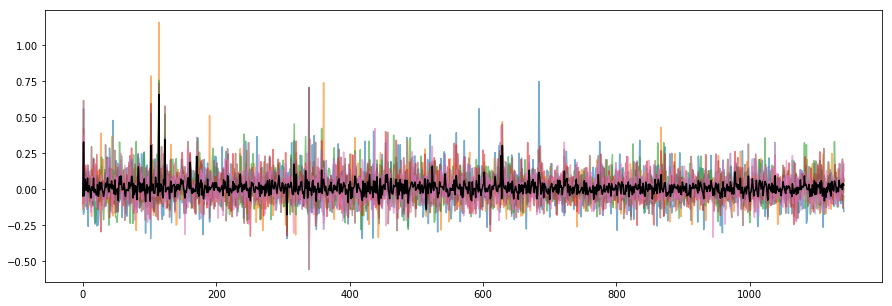

In [3]:
si=101
plt.figure(figsize=[15,5])
for i in range(8):
    plt.plot(FullRsp[:,i,si],alpha=0.6)
plt.plot(FullRsp[:,:,si].sum(axis=1)/NumT[:,si],color='black')
plt.show()

### Sparsity 

In [27]:
Thr=0.2
RspPeakcnt=len((FullRsp>0.2).nonzero()[0])
print("Threshold:%.1f\tSparsity:%.4f"%(Thr,RspPeakcnt/NumT.sum()))

Threshold:0.2	Sparsity:0.0635


For same stimuli, there is several trials and the variability is bit.
And Neural network is deterministic, so we can only fit the mean. 
(Maybe the variance can be used as weight)

Note that some neurons sometimes has **no signal/trial**, so we must exclude them when averaging

In [8]:
np.nonzero(NumT==0)

(array([ 98,  98,  98, ..., 763, 763, 763]),
 array([  10,   11,   12, ..., 9477, 9478, 9479]))

In [9]:
np.unique(np.nonzero(NumT==0)[0])

array([ 98, 148, 643, 703, 763])

In [10]:
LostId=np.unique(np.nonzero(NumT==0)[0])
Msk=np.asarray([i not in LostId for i in range(1142)])

In [11]:
SelAvgRsp=FullRsp[Msk,:,:].sum(axis=1)/NumT[Msk,:]

## Read in Shapes Stimuli

In [4]:
Stimuli = scipy.io.loadmat(Dir+"Shape/Shapedata.mat")
Stimuli = Stimuli['ShapeStimi']

In [56]:
Stimuli.shape

(9500, 160, 160)

In [60]:
Stimuli.dtype

dtype('uint8')

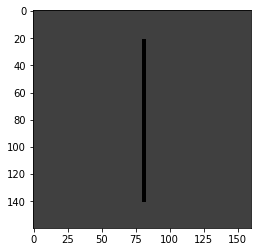

In [9]:
si=101
plt.figure()
plt.imshow(Stimuli[si,:,:],cmap=plt.cm.gray,vmin=0,vmax=256)
plt.show()

### Receptive Field Estimation-Response Weighted Average

In [5]:
AvgStimi=(64-Stimuli.mean(axis=0))/64
NormStimuli=(64-Stimuli)/64

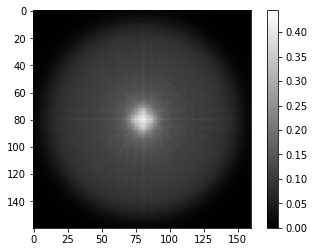

In [6]:
plt.figure()
plt.imshow(AvgStimi,cmap=plt.cm.gray)#,vmin=0,vmax=256
plt.colorbar()
plt.show()

In [93]:
AvgStimi

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


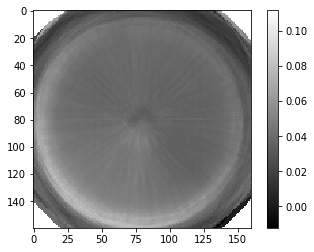

In [20]:
ci=123
meanRsp=SelAvgRsp[ci,:].mean()
WAvgStimi=np.einsum('i,ijk',SelAvgRsp[ci,:],NormStimuli)/len(Stimuli)/AvgStimi#/meanRsp
plt.figure()
plt.imshow(WAvgStimi,cmap=plt.cm.gray)#,vmin=0,vmax=256
plt.colorbar()
plt.show()
# 结果很好的ci 102 

In [60]:
WAvgStimi

array([[ 0.02059386,  0.02059386,  0.02059386, ...,  0.02059386,
         0.02059386,  0.02059386],
       [ 0.02059386,  0.02059386,  0.02059386, ...,  0.02059386,
         0.02059386,  0.02059386],
       [ 0.02059386,  0.02059386,  0.02059386, ...,  0.02059386,
         0.02059386,  0.02059386],
       ..., 
       [ 0.02059386,  0.02059386,  0.02059386, ...,  0.02059386,
         0.02059386,  0.02059386],
       [ 0.02059386,  0.02059386,  0.02059386, ...,  0.02059386,
         0.02059386,  0.02059386],
       [ 0.02059386,  0.02059386,  0.02059386, ...,  0.02059386,
         0.02059386,  0.02059386]])

## Neural Network Model Building Site

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

In [97]:
StimTsr = torch.from_numpy(Stimuli[:,:,:])# Convert to tensor and Change to variable
#StimTsr.byte()# This Tensor by default is ByteTensor, actually it can be a boolean :(

In [206]:
StimTsr=StimTsr.contiguous().view(9500,1,160,160).float() # Must add contiguous Transform or view() will raise error

In [127]:
StimTsrSlice=Variable(StimTsr[0:1000:10,:,:,:],requires_grad=False)
# Cast it float will cost a lot of memory, But convolution weights are float so here we must do so. 

In [182]:
SelAvgRsp=torch.from_numpy(SelAvgRsp).float()
#SelAvgRsp.t()
AvgRspSlice=Variable(SelAvgRsp[:,0:1000:10],requires_grad=False)# Rsponse Slicing
# Cast to float or there will be type err

In [183]:
AvgRspSlice.t()

Variable containing:
 1.3377e-02  3.8199e-02  1.3194e-01  ...   8.3996e-02  3.1304e-02  2.0064e-02
 1.2747e-01 -3.9632e-02  1.3761e-01  ...  -5.8132e-03  3.2270e-02  4.1986e-02
-3.8421e-02 -7.0188e-04  7.5869e-02  ...  -3.6602e-03  1.4478e-02  4.5736e-02
                ...                   ⋱                   ...                
 1.9016e-02  2.6957e-02  2.2696e-02  ...   5.9347e-02 -9.1797e-03 -3.6266e-02
-6.5025e-03 -3.6181e-02  4.2193e-02  ...   5.8310e-02  1.8286e-02 -1.0940e-02
 4.9527e-02  9.2577e-02 -2.5822e-02  ...  -5.9339e-02  5.1618e-02 -5.6729e-02
[torch.FloatTensor of size 100x1137]

In [195]:
AvgRspSlice.size()

torch.Size([1137, 100])

### Models

In [129]:
convL=nn.Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))# Size invariant conv

In [134]:
stimflt=convL.forward(StimTsrSlice)

In [178]:
linL=nn.Linear(160*160*10,1142-5)

In [179]:
Out=linL(stimflt.view(100,-1))

In [180]:
Out

Variable containing:
-4.7280e+01 -1.9446e+01  1.2969e+01  ...   1.8809e+01 -1.2032e+01 -3.2928e+01
-6.3668e+01 -2.6440e+01  2.9960e+01  ...   1.5335e+01 -5.1934e+00 -3.1807e+01
-4.9647e+01 -2.4150e+01  2.4440e+01  ...   1.1825e+01 -1.0800e+01 -3.2468e+01
                ...                   ⋱                   ...                
-5.7789e+01 -2.9150e+01  3.7060e+01  ...   2.0607e+01 -1.9737e+01 -3.0895e+01
-5.3077e+01 -2.7114e+01  3.7637e+01  ...   2.2746e+01 -2.0586e+01 -2.8597e+01
-5.8645e+01 -3.1479e+01  3.6915e+01  ...   2.0098e+01 -1.6660e+01 -2.9437e+01
[torch.FloatTensor of size 100x1137]

In [185]:
LossFun=nn.MSELoss()

In [186]:
Loss=LossFun(Out,AvgRspSlice.t())

In [ ]:
Loss.backward()

## Wrapping

Credit goes to https://github.com/pytorch/examples/blob/master/mnist/main.py

In [198]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.fc1 = nn.Linear(160*160*10,1142-5)

    def forward(self, x):
        B,C,H,W=x.size()
        x = nn.functional.relu(self.conv1(x))
        x = x.view(B*C,-1)
        x = nn.functional.relu(self.fc1(x))
        return x

model = Net()

In [199]:
model(StimTsrSlice)

Variable containing:
  0.0000   0.0000   0.0000  ...    0.0000   3.3307   7.5825
  0.0000   0.0000   0.0000  ...    0.0000   7.5551   5.6877
  0.0000   0.0000   1.0882  ...    0.0000   4.4222   3.6006
           ...               ⋱              ...            
  0.0000   3.0352   0.0000  ...    0.0000   6.3304   9.7863
  0.0000   0.0000   0.0119  ...    0.0000   6.3991   9.9737
  0.0000   0.1910   0.0000  ...    0.0000   7.8033   9.6250
[torch.FloatTensor of size 100x1137]

### Dataset prepare

In [215]:
from torch.utils.data import TensorDataset,DataLoader,RandomSampler
from torch.utils.data.sampler import RandomSampler

In [217]:
ShapeDataset=TensorDataset(StimTsr,SelAvgRsp.t())

Random sampling to separate training and testing set

In [225]:
p=0.3# Test Sample size
ind=np.random.choice(9500,int(9500*p),replace=False,p=None)
ind.sort()# Test id List
nind=[]
for i in range(9500):
    if i not in ind:
        nind.append(i)
nind=np.asarray(nind)# Training id List
nind

array([   0,    2,    3, ..., 9494, 9495, 9498])

In [244]:
TrainDataset=TensorDataset(StimTsr[nind,:,:,:],SelAvgRsp[:,nind].t())
TestDataset=TensorDataset(StimTsr[ind,:,:,:],SelAvgRsp[:,ind].t())

In [245]:
batch_size=100
train_loader=DataLoader(TrainDataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader=DataLoader(TrainDataset, batch_size=batch_size, shuffle=True, drop_last=False)

In [240]:
optimizer = optim.SGD(model.parameters(),lr=0.1,momentum=0.9)#, lr=args.lr, momentum=args.momentum)
def train(epoch,iteration=1):
    model.train()
    for j in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target) 
            for i in range(iteration):
                optimizer.zero_grad()
                output = model(data)
                loss = nn.functional.mse_loss(output, target)
                loss.backward()
                optimizer.step()
                #if i % 10 == 0:
                #    print('Iteration: {} \t Loss: {:.6f}'.format(
                #        i,loss.data[0]))
            if batch_idx%5==0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    j, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))

In [241]:
train(1,3)

Train Epoch: 0 [100/6650 (1%)]	Loss: 0.004911
Train Epoch: 0 [200/6650 (3%)]	Loss: 0.005045
Train Epoch: 0 [300/6650 (4%)]	Loss: 0.005143
Train Epoch: 0 [400/6650 (6%)]	Loss: 0.005313
Train Epoch: 0 [600/6650 (9%)]	Loss: 0.004840
Train Epoch: 0 [700/6650 (10%)]	Loss: 0.005069
Train Epoch: 0 [800/6650 (12%)]	Loss: 0.005306
Train Epoch: 0 [900/6650 (13%)]	Loss: 0.005254
Train Epoch: 0 [1100/6650 (16%)]	Loss: 0.005060
Train Epoch: 0 [1200/6650 (18%)]	Loss: 0.005289
Train Epoch: 0 [1300/6650 (19%)]	Loss: 0.004892
Train Epoch: 0 [1400/6650 (21%)]	Loss: 0.005165
Train Epoch: 0 [1600/6650 (24%)]	Loss: 0.005118
Train Epoch: 0 [1700/6650 (25%)]	Loss: 0.005068
Train Epoch: 0 [1800/6650 (27%)]	Loss: 0.005259
Train Epoch: 0 [1900/6650 (28%)]	Loss: 0.005219
Train Epoch: 0 [2100/6650 (31%)]	Loss: 0.005200
Train Epoch: 0 [2200/6650 (33%)]	Loss: 0.005323
Train Epoch: 0 [2300/6650 (34%)]	Loss: 0.005179
Train Epoch: 0 [2400/6650 (36%)]	Loss: 0.005344
Train Epoch: 0 [2600/6650 (39%)]	Loss: 0.004781
Train

In [247]:
def test():
    test_loss = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        loss = nn.functional.mse_loss(output, target) # sum up batch loss
        test_loss +=loss*len(data)
    test_loss = test_loss/len(test_loader.dataset)
    print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.data[0]))

In [248]:
test()


Test set: Average loss: 0.004973



In [250]:
i=np.random.choice(ind,1)

In [251]:
i

array([8335])

In [290]:
i=np.random.choice(ind,1)[0]

xi=Variable(StimTsr[i:i+1,:,:,:], volatile=True)
Rspi=SelAvgRsp[:,i]
Rspinfer=model(xi)
loss = nn.functional.mse_loss(Rspinfer,Rspi)
print("Stmulus #%d, Loss %.6f" %(i,loss.data[0]))

Stmulus #5742, Loss 0.004684


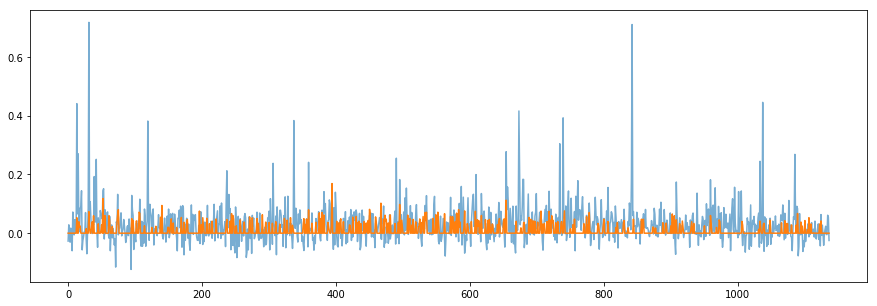

In [291]:
plt.figure(figsize=[15,5])
plt.plot(Rspi.numpy(),alpha=0.6)
plt.plot(Rspinfer.data.numpy()[0])
plt.show()

## Issue & details to discuss

The training Fails majorly because of the **sparsity of signal** !! We are fitting noise now. 
Need a better loss function! 

About Data and Loss
* Sparseness of Data (input and output both). Can we Train well?
* Noisiness of Response Data 
    * Must avoid fitting noise in the end!!
* Which Loss is good for use? MSE (L2) is the easiest

About Training 
* Batch size?
* Now the training

About Model Structure
* Depth? how many convolution layers (now (1 conv 1 pooling 1 relu) 1 Linear regression)
* Size of convolution kernel. 
    * And its relationship to receptive field of V1 neuron
* Other fancy convolution method? 
    * Deformable conv
* Better Linear layer (Too many params now!!!~$10^8$)
* Newer idea other than CNN? [Hinton's Capsule Network](https://medium.com/ai³-theory-practice-business/understanding-hintons-capsule-networks-part-i-intuition-b4b559d1159b)

Other Biological Constraint?
* Differentiate between Inhibitory and Excitatory ?
* Constraint the strength of input

-----------

## Miscelany

In [22]:
x = Variable(torch.ones(1, 3,5,5) * 2, requires_grad=True)

In [31]:
linL.forward(fm.view(-1))

Variable containing:
-0.0292
-0.8466
 0.4799
 0.2451
 0.0567
 1.1983
-0.0509
-0.0489
-0.0624
-0.2993
[torch.FloatTensor of size 10]

In [29]:
fm.view(-1,5*5)

Variable containing:

Columns 0 to 9 
 0.3376 -0.1651 -0.1651 -0.1651 -0.3013  0.3843  0.5740  0.5740  0.5740 -0.1898
-1.4400 -1.6181 -1.6181 -1.6181 -1.5903 -1.4582 -1.3826 -1.3826 -1.3826 -2.0335
 0.6950  0.3824  0.3824  0.3824 -0.4695  0.2206  0.0575  0.0575  0.0575 -0.2552
-0.4973 -0.8197 -0.8197 -0.8197 -1.0869 -0.7840 -0.5599 -0.5599 -0.5599 -1.0227
 1.3012  1.2144  1.2144  1.2144 -0.2758  2.1142  2.1859  2.1859  2.1859  0.1497
 1.0372  0.9856  0.9856  0.9856  0.4693  1.4281  1.1298  1.1298  1.1298  1.0550
-1.4019 -0.6243 -0.6243 -0.6243  0.8228 -1.0067 -0.3757 -0.3757 -0.3757  1.3684
 0.4409  0.0692  0.0692  0.0692 -0.4383 -0.1314 -0.3046 -0.3046 -0.3046 -0.3154
-0.7564 -0.4262 -0.4262 -0.4262 -0.3361 -1.5480 -1.5410 -1.5410 -1.5410 -1.3128
 0.4856  0.3436  0.3436  0.3436  0.0899  0.5266  0.1189  0.1189  0.1189 -0.5123

Columns 10 to 19 
 0.3843  0.5740  0.5740  0.5740 -0.1898  0.3843  0.5740  0.5740  0.5740 -0.1898
-1.4582 -1.3826 -1.3826 -1.3826 -2.0335 -1.4582 -1.3826 -1.3826

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        #self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = Net()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Comparing with Pretrained VGG models?

In [2]:
cnn = models.vgg19(pretrained=True).features

In [124]:
y=StimVar[1,0,1,1:5]*torch.from_numpy(1.5)

RuntimeError: from_numpy expects an np.ndarray but got float